In [1]:
#!pip install einops

In [2]:
import os
import sys
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from einops import rearrange


/tmp/ipykernel_4518/676446573.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# module_path = '/home/srikanth/Downloads/conformer_helpers'
# sys.path.append(os.path.dirname(module_path))

In [5]:
module_path = '/home/srikanth/Downloads/going_modular'
sys.path.append(os.path.dirname(module_path))

In [6]:
from going_modular.helper_functions import set_seeds
from going_modular import engine
from going_modular.helper_functions import plot_loss_curves

/home/srikanth/graspenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
root_path = r"/home/srikanth/Dataset/Hit-GPRec-merged"
dataset_path = os.listdir(root_path)

CREATE DATASET AND DATALOADERS

In [8]:
class_labels = []

for item in dataset_path:
    #print(item)
    all_classes = os.listdir(root_path + '/' +item)
    for top_object in all_classes:
        class_labels.append((item,str(root_path + '/' +item + '/' +top_object)))
        #sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
#         for sub_object in sub_objects:
#             class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object)))

df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [9]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [10]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((49, 49), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [11]:
def create_dataloaders(train_df,test_df,val_df,batch_size: int):
    # Use ImageFolder to create dataset(s)
    train_data = ImageDataset(train_df)
    test_data = ImageDataset(test_df)
    val_data = ImageDataset(val_df)

    # Get class names
    class_names = list(train_df['labels'].unique())

   # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True)
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False)
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False)

    return train_dataloader, test_dataloader, val_dataloader, class_names

MODEL

In [12]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x



In [13]:
class CViT(nn.Module):
    def __init__(self, image_size=49, patch_size=7, num_classes=4, channels=3,
                 dim=1024, depth=6, heads=8, mlp_dim=2048):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding = 1),   #changed stride 2 to 1

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1,),   #changed stride 2 to 1

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted stride from 2 to 1

        )

        num_patches = (7 // patch_size) ** 2
        patch_dim = 512 * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(32, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = self.features(img)
        #print(x.shape)
        y = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        y = self.patch_to_embedding(y)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, y), 1)
        #batch_size = x.shape[0]
        #expanded_pos_embedding = self.pos_embedding[:batch_size]
        shape=x.shape[0]
        #x = torch.cat((cls_tokens, y), 1)
        #x += expanded_pos_embedding
        x += self.pos_embedding[0:shape]
        x = self.transformer(x, mask)
        x = self.to_cls_token(x[:, 0])

        return self.mlp_head(x)

PROCESSING

In [14]:
#For MODEL INPUT
LR=0.0001
EPOCHS=40
BATCH_SIZE = 16
#img_size=(IMGSIZE, IMGSIZE) # USER DEFINED
#channels=3
#img_shape=(img_size[0], img_size[1], channels)

100%|█████████████████████████████████████████| 296/296 [00:10<00:00, 27.78it/s]


Epoch: 1 | train_loss: 0.4859 | train_acc: 0.8193 | test_loss: 1.0856 | test_acc: 0.6560


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.07it/s]


Epoch: 2 | train_loss: 0.2082 | train_acc: 0.9254 | test_loss: 1.7465 | test_acc: 0.6571


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.53it/s]


Epoch: 3 | train_loss: 0.1365 | train_acc: 0.9525 | test_loss: 1.2139 | test_acc: 0.7111


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.91it/s]


Epoch: 4 | train_loss: 0.1018 | train_acc: 0.9657 | test_loss: 1.5792 | test_acc: 0.7363


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.94it/s]


Epoch: 5 | train_loss: 0.0842 | train_acc: 0.9720 | test_loss: 1.8008 | test_acc: 0.7413


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.79it/s]


Epoch: 6 | train_loss: 0.0733 | train_acc: 0.9756 | test_loss: 1.2188 | test_acc: 0.7249


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.79it/s]


Epoch: 7 | train_loss: 0.0958 | train_acc: 0.9729 | test_loss: 1.3781 | test_acc: 0.7335


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.01it/s]


Epoch: 8 | train_loss: 0.0427 | train_acc: 0.9857 | test_loss: 1.8783 | test_acc: 0.7238


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.97it/s]


Epoch: 9 | train_loss: 0.0434 | train_acc: 0.9848 | test_loss: 1.5945 | test_acc: 0.7240


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.87it/s]


Epoch: 10 | train_loss: 0.1577 | train_acc: 0.9544 | test_loss: 1.1276 | test_acc: 0.7325


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.04it/s]


Epoch: 11 | train_loss: 0.0528 | train_acc: 0.9809 | test_loss: 1.3844 | test_acc: 0.7720


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.87it/s]


Epoch: 12 | train_loss: 0.0386 | train_acc: 0.9875 | test_loss: 2.0545 | test_acc: 0.7437


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.67it/s]


Epoch: 13 | train_loss: 0.0292 | train_acc: 0.9901 | test_loss: 2.1438 | test_acc: 0.6860


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.30it/s]


Epoch: 14 | train_loss: 0.0325 | train_acc: 0.9895 | test_loss: 1.1103 | test_acc: 0.7475


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.02it/s]


Epoch: 15 | train_loss: 0.0369 | train_acc: 0.9879 | test_loss: 1.3414 | test_acc: 0.7783


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.76it/s]


Epoch: 16 | train_loss: 0.0393 | train_acc: 0.9880 | test_loss: 1.7190 | test_acc: 0.6974


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.86it/s]


Epoch: 17 | train_loss: 0.0370 | train_acc: 0.9890 | test_loss: 1.6931 | test_acc: 0.7337


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.57it/s]


Epoch: 18 | train_loss: 0.0290 | train_acc: 0.9902 | test_loss: 1.4401 | test_acc: 0.7694


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.77it/s]


Epoch: 19 | train_loss: 0.0355 | train_acc: 0.9901 | test_loss: 1.3303 | test_acc: 0.8072


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.91it/s]


Epoch: 20 | train_loss: 0.0218 | train_acc: 0.9930 | test_loss: 1.1274 | test_acc: 0.7158


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.97it/s]


Epoch: 21 | train_loss: 0.0320 | train_acc: 0.9901 | test_loss: 1.7003 | test_acc: 0.7485


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.97it/s]


Epoch: 22 | train_loss: 0.0201 | train_acc: 0.9942 | test_loss: 1.4767 | test_acc: 0.7515


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.98it/s]


Epoch: 23 | train_loss: 0.0237 | train_acc: 0.9934 | test_loss: 1.7370 | test_acc: 0.7340


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.87it/s]


Epoch: 24 | train_loss: 0.0231 | train_acc: 0.9927 | test_loss: 2.3113 | test_acc: 0.7175


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.05it/s]


Epoch: 25 | train_loss: 0.0239 | train_acc: 0.9929 | test_loss: 1.7784 | test_acc: 0.7109


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.98it/s]


Epoch: 26 | train_loss: 0.0223 | train_acc: 0.9934 | test_loss: 2.2753 | test_acc: 0.7259


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.92it/s]


Epoch: 27 | train_loss: 0.0284 | train_acc: 0.9918 | test_loss: 1.9343 | test_acc: 0.7162


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.25it/s]


Epoch: 28 | train_loss: 0.0136 | train_acc: 0.9956 | test_loss: 2.6830 | test_acc: 0.7257


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.98it/s]


Epoch: 29 | train_loss: 0.0161 | train_acc: 0.9953 | test_loss: 1.9740 | test_acc: 0.7517


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.86it/s]


Epoch: 30 | train_loss: 0.0200 | train_acc: 0.9940 | test_loss: 1.1978 | test_acc: 0.7641


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.94it/s]


Epoch: 31 | train_loss: 0.0129 | train_acc: 0.9962 | test_loss: 2.0236 | test_acc: 0.6841


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.58it/s]


Epoch: 32 | train_loss: 0.0202 | train_acc: 0.9937 | test_loss: 1.9762 | test_acc: 0.7147


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.89it/s]


Epoch: 33 | train_loss: 0.0170 | train_acc: 0.9949 | test_loss: 1.8994 | test_acc: 0.7561


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.96it/s]


Epoch: 34 | train_loss: 0.0145 | train_acc: 0.9957 | test_loss: 1.8055 | test_acc: 0.7088


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.20it/s]


Epoch: 35 | train_loss: 0.0136 | train_acc: 0.9967 | test_loss: 1.4529 | test_acc: 0.7500


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.04it/s]


Epoch: 36 | train_loss: 0.0146 | train_acc: 0.9961 | test_loss: 2.2844 | test_acc: 0.7365


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.67it/s]


Epoch: 37 | train_loss: 0.0149 | train_acc: 0.9956 | test_loss: 1.6121 | test_acc: 0.6721


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 31.18it/s]


Epoch: 38 | train_loss: 0.0157 | train_acc: 0.9960 | test_loss: 2.6038 | test_acc: 0.7523


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.68it/s]


Epoch: 39 | train_loss: 0.0109 | train_acc: 0.9970 | test_loss: 2.3041 | test_acc: 0.7264


100%|█████████████████████████████████████████| 296/296 [00:09<00:00, 30.94it/s]


Epoch: 40 | train_loss: 0.0118 | train_acc: 0.9965 | test_loss: 3.8254 | test_acc: 0.7549
Confusion matrix: 
[[ 576    0    0    0]
 [   0  686  170    8]
 [  71   39 2211  238]
 [  11    0  443  378]]
Precision: 0.7926443015116248
Recall: 0.7971434485613744
F1 score: 0.7902893488893182


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.92it/s]


Epoch: 1 | train_loss: 0.4871 | train_acc: 0.8105 | test_loss: 0.6595 | test_acc: 0.7618


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.52it/s]


Epoch: 2 | train_loss: 0.2174 | train_acc: 0.9202 | test_loss: 0.9265 | test_acc: 0.7167


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.66it/s]


Epoch: 3 | train_loss: 0.2463 | train_acc: 0.9157 | test_loss: 0.3951 | test_acc: 0.8516


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.88it/s]


Epoch: 4 | train_loss: 0.1072 | train_acc: 0.9631 | test_loss: 0.8678 | test_acc: 0.7591


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.35it/s]


Epoch: 5 | train_loss: 0.0946 | train_acc: 0.9673 | test_loss: 0.8861 | test_acc: 0.7887


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.71it/s]


Epoch: 6 | train_loss: 0.0840 | train_acc: 0.9716 | test_loss: 0.7672 | test_acc: 0.7995


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.79it/s]


Epoch: 7 | train_loss: 0.0614 | train_acc: 0.9792 | test_loss: 0.9482 | test_acc: 0.7852


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.92it/s]


Epoch: 8 | train_loss: 0.0534 | train_acc: 0.9820 | test_loss: 0.5793 | test_acc: 0.8431


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.69it/s]


Epoch: 9 | train_loss: 0.0532 | train_acc: 0.9825 | test_loss: 0.9083 | test_acc: 0.7409


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.73it/s]


Epoch: 10 | train_loss: 0.0440 | train_acc: 0.9853 | test_loss: 1.1752 | test_acc: 0.8115


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.88it/s]


Epoch: 11 | train_loss: 0.0370 | train_acc: 0.9877 | test_loss: 1.5631 | test_acc: 0.7384


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.89it/s]


Epoch: 12 | train_loss: 0.0391 | train_acc: 0.9875 | test_loss: 1.1015 | test_acc: 0.8212


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.77it/s]


Epoch: 13 | train_loss: 0.0406 | train_acc: 0.9879 | test_loss: 0.8404 | test_acc: 0.7895


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.76it/s]


Epoch: 14 | train_loss: 0.0290 | train_acc: 0.9905 | test_loss: 0.6878 | test_acc: 0.8144


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.92it/s]


Epoch: 15 | train_loss: 0.0313 | train_acc: 0.9899 | test_loss: 0.8914 | test_acc: 0.8326


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.81it/s]


Epoch: 16 | train_loss: 0.0235 | train_acc: 0.9927 | test_loss: 1.0537 | test_acc: 0.7941


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.74it/s]


Epoch: 17 | train_loss: 0.0334 | train_acc: 0.9896 | test_loss: 1.2636 | test_acc: 0.7916


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.84it/s]


Epoch: 18 | train_loss: 0.0268 | train_acc: 0.9919 | test_loss: 1.6147 | test_acc: 0.7523


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.45it/s]


Epoch: 19 | train_loss: 0.0249 | train_acc: 0.9919 | test_loss: 0.5430 | test_acc: 0.8235


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.57it/s]


Epoch: 20 | train_loss: 0.0241 | train_acc: 0.9926 | test_loss: 1.1988 | test_acc: 0.7781


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.74it/s]


Epoch: 21 | train_loss: 0.0213 | train_acc: 0.9934 | test_loss: 0.8270 | test_acc: 0.8373


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.74it/s]


Epoch: 22 | train_loss: 0.0248 | train_acc: 0.9926 | test_loss: 1.5569 | test_acc: 0.8129


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.88it/s]


Epoch: 23 | train_loss: 0.0188 | train_acc: 0.9949 | test_loss: 0.6868 | test_acc: 0.8419


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.66it/s]


Epoch: 24 | train_loss: 0.2076 | train_acc: 0.9346 | test_loss: 0.3926 | test_acc: 0.8506


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.89it/s]


Epoch: 25 | train_loss: 0.0586 | train_acc: 0.9798 | test_loss: 0.7370 | test_acc: 0.8237


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.57it/s]


Epoch: 26 | train_loss: 0.0135 | train_acc: 0.9952 | test_loss: 0.8059 | test_acc: 0.8535


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.51it/s]


Epoch: 27 | train_loss: 0.0094 | train_acc: 0.9969 | test_loss: 1.3459 | test_acc: 0.8160


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.85it/s]


Epoch: 28 | train_loss: 0.0172 | train_acc: 0.9953 | test_loss: 1.0435 | test_acc: 0.8154


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.48it/s]


Epoch: 29 | train_loss: 0.0241 | train_acc: 0.9930 | test_loss: 0.9236 | test_acc: 0.8419


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.74it/s]


Epoch: 30 | train_loss: 0.0173 | train_acc: 0.9943 | test_loss: 0.8098 | test_acc: 0.8369


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.66it/s]


Epoch: 31 | train_loss: 0.0207 | train_acc: 0.9944 | test_loss: 0.9449 | test_acc: 0.8299


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.58it/s]


Epoch: 32 | train_loss: 0.0176 | train_acc: 0.9948 | test_loss: 0.8831 | test_acc: 0.8249


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.81it/s]


Epoch: 33 | train_loss: 0.0150 | train_acc: 0.9959 | test_loss: 1.7310 | test_acc: 0.8115


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.92it/s]


Epoch: 34 | train_loss: 0.0173 | train_acc: 0.9953 | test_loss: 1.5466 | test_acc: 0.8185


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.81it/s]


Epoch: 35 | train_loss: 0.0196 | train_acc: 0.9945 | test_loss: 0.9396 | test_acc: 0.8247


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.58it/s]


Epoch: 36 | train_loss: 0.0116 | train_acc: 0.9971 | test_loss: 1.2226 | test_acc: 0.8069


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.62it/s]


Epoch: 37 | train_loss: 0.0134 | train_acc: 0.9966 | test_loss: 1.2656 | test_acc: 0.8019


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.80it/s]


Epoch: 38 | train_loss: 0.0161 | train_acc: 0.9957 | test_loss: 1.3573 | test_acc: 0.8173


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.90it/s]


Epoch: 39 | train_loss: 0.0200 | train_acc: 0.9945 | test_loss: 0.7504 | test_acc: 0.8425


100%|█████████████████████████████████████████| 302/302 [00:09<00:00, 31.89it/s]


Epoch: 40 | train_loss: 0.0066 | train_acc: 0.9982 | test_loss: 1.3343 | test_acc: 0.8220
Confusion matrix: 
[[ 293   42   42   39]
 [   0  754  110    0]
 [   1   22 2391   18]
 [   3   28  362  407]]
Precision: 0.8607834386783537
Recall: 0.8521719858156028
F1 score: 0.8417824494164962


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.09it/s]


Epoch: 1 | train_loss: 0.4937 | train_acc: 0.8128 | test_loss: 0.6740 | test_acc: 0.7550


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.13it/s]


Epoch: 2 | train_loss: 0.2108 | train_acc: 0.9231 | test_loss: 0.7250 | test_acc: 0.8040


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.26it/s]


Epoch: 3 | train_loss: 0.1327 | train_acc: 0.9538 | test_loss: 0.4806 | test_acc: 0.8575


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.00it/s]


Epoch: 4 | train_loss: 0.2164 | train_acc: 0.9216 | test_loss: 0.5093 | test_acc: 0.8556


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.96it/s]


Epoch: 5 | train_loss: 0.0778 | train_acc: 0.9725 | test_loss: 0.4080 | test_acc: 0.8907


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.21it/s]


Epoch: 6 | train_loss: 0.0801 | train_acc: 0.9729 | test_loss: 0.4453 | test_acc: 0.8730


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.36it/s]


Epoch: 7 | train_loss: 0.0682 | train_acc: 0.9764 | test_loss: 0.2932 | test_acc: 0.9060


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.22it/s]


Epoch: 8 | train_loss: 0.0553 | train_acc: 0.9818 | test_loss: 0.8243 | test_acc: 0.7856


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.32it/s]


Epoch: 9 | train_loss: 0.0477 | train_acc: 0.9840 | test_loss: 0.6686 | test_acc: 0.8503


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.05it/s]


Epoch: 10 | train_loss: 0.0430 | train_acc: 0.9868 | test_loss: 0.7102 | test_acc: 0.8431


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.26it/s]


Epoch: 11 | train_loss: 0.0413 | train_acc: 0.9870 | test_loss: 0.9383 | test_acc: 0.7933


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.98it/s]


Epoch: 12 | train_loss: 0.0443 | train_acc: 0.9859 | test_loss: 0.9487 | test_acc: 0.8429


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.30it/s]


Epoch: 13 | train_loss: 0.0294 | train_acc: 0.9910 | test_loss: 0.9484 | test_acc: 0.8184


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.30it/s]


Epoch: 14 | train_loss: 0.0379 | train_acc: 0.9880 | test_loss: 0.7834 | test_acc: 0.8636


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.04it/s]


Epoch: 15 | train_loss: 0.0324 | train_acc: 0.9900 | test_loss: 0.7495 | test_acc: 0.8302


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.27it/s]


Epoch: 16 | train_loss: 0.0281 | train_acc: 0.9914 | test_loss: 0.9035 | test_acc: 0.8420


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.23it/s]


Epoch: 17 | train_loss: 0.0249 | train_acc: 0.9925 | test_loss: 0.9615 | test_acc: 0.8337


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.17it/s]


Epoch: 18 | train_loss: 0.0246 | train_acc: 0.9924 | test_loss: 1.2588 | test_acc: 0.8164


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.27it/s]


Epoch: 19 | train_loss: 0.0203 | train_acc: 0.9940 | test_loss: 0.8817 | test_acc: 0.8499


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.26it/s]


Epoch: 20 | train_loss: 0.0194 | train_acc: 0.9941 | test_loss: 0.6982 | test_acc: 0.8702


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.28it/s]


Epoch: 21 | train_loss: 0.0293 | train_acc: 0.9912 | test_loss: 0.8018 | test_acc: 0.8453


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.04it/s]


Epoch: 22 | train_loss: 0.0176 | train_acc: 0.9945 | test_loss: 0.7456 | test_acc: 0.8365


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.96it/s]


Epoch: 23 | train_loss: 0.0200 | train_acc: 0.9938 | test_loss: 1.4461 | test_acc: 0.8311


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.75it/s]


Epoch: 24 | train_loss: 0.0188 | train_acc: 0.9943 | test_loss: 1.1229 | test_acc: 0.8274


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.29it/s]


Epoch: 25 | train_loss: 0.0111 | train_acc: 0.9964 | test_loss: 1.6463 | test_acc: 0.8394


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.95it/s]


Epoch: 26 | train_loss: 0.0222 | train_acc: 0.9941 | test_loss: 1.2580 | test_acc: 0.8125


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.27it/s]


Epoch: 27 | train_loss: 0.0126 | train_acc: 0.9964 | test_loss: 1.8626 | test_acc: 0.7948


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.11it/s]


Epoch: 28 | train_loss: 0.0180 | train_acc: 0.9952 | test_loss: 0.4882 | test_acc: 0.8767


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.15it/s]


Epoch: 29 | train_loss: 0.0143 | train_acc: 0.9959 | test_loss: 1.1986 | test_acc: 0.8295


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.11it/s]


Epoch: 30 | train_loss: 0.0142 | train_acc: 0.9959 | test_loss: 1.2629 | test_acc: 0.8129


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.28it/s]


Epoch: 31 | train_loss: 0.0135 | train_acc: 0.9961 | test_loss: 1.1281 | test_acc: 0.8254


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.17it/s]


Epoch: 32 | train_loss: 0.0136 | train_acc: 0.9961 | test_loss: 0.8965 | test_acc: 0.8494


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.00it/s]


Epoch: 33 | train_loss: 0.0160 | train_acc: 0.9955 | test_loss: 1.1220 | test_acc: 0.8182


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.19it/s]


Epoch: 34 | train_loss: 0.0088 | train_acc: 0.9974 | test_loss: 0.9665 | test_acc: 0.8682


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.68it/s]


Epoch: 35 | train_loss: 0.0113 | train_acc: 0.9966 | test_loss: 1.3826 | test_acc: 0.8339


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.92it/s]


Epoch: 36 | train_loss: 0.0195 | train_acc: 0.9945 | test_loss: 1.2910 | test_acc: 0.8250


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.01it/s]


Epoch: 37 | train_loss: 0.0087 | train_acc: 0.9976 | test_loss: 1.7822 | test_acc: 0.8298


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 29.00it/s]


Epoch: 38 | train_loss: 0.0195 | train_acc: 0.9966 | test_loss: 1.1580 | test_acc: 0.8344


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.97it/s]


Epoch: 39 | train_loss: 0.0087 | train_acc: 0.9976 | test_loss: 1.5284 | test_acc: 0.8370


100%|█████████████████████████████████████████| 286/286 [00:09<00:00, 28.79it/s]


Epoch: 40 | train_loss: 0.0104 | train_acc: 0.9971 | test_loss: 1.5314 | test_acc: 0.8431
Confusion matrix: 
[[ 576    0    0    0]
 [   0  918  141    0]
 [   8   83 2520  215]
 [  22    2  366  448]]
Precision: 0.837074121310318
Recall: 0.8420456689941498
F1 score: 0.8375171645858298


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.63it/s]


Epoch: 1 | train_loss: 0.4741 | train_acc: 0.8106 | test_loss: 1.4208 | test_acc: 0.6712


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.38it/s]


Epoch: 2 | train_loss: 0.1934 | train_acc: 0.9282 | test_loss: 1.3294 | test_acc: 0.7120


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.64it/s]


Epoch: 3 | train_loss: 0.1317 | train_acc: 0.9535 | test_loss: 1.5037 | test_acc: 0.6987


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.79it/s]


Epoch: 4 | train_loss: 0.0838 | train_acc: 0.9707 | test_loss: 1.2604 | test_acc: 0.7819


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.63it/s]


Epoch: 5 | train_loss: 0.1031 | train_acc: 0.9659 | test_loss: 1.4043 | test_acc: 0.7590


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.59it/s]


Epoch: 6 | train_loss: 0.0593 | train_acc: 0.9802 | test_loss: 1.8508 | test_acc: 0.7535


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.52it/s]


Epoch: 7 | train_loss: 0.0568 | train_acc: 0.9811 | test_loss: 1.2704 | test_acc: 0.7717


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.56it/s]


Epoch: 8 | train_loss: 0.0565 | train_acc: 0.9818 | test_loss: 1.7530 | test_acc: 0.7831


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.62it/s]


Epoch: 9 | train_loss: 0.0469 | train_acc: 0.9850 | test_loss: 1.8738 | test_acc: 0.8068


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.77it/s]


Epoch: 10 | train_loss: 0.0416 | train_acc: 0.9866 | test_loss: 2.0885 | test_acc: 0.7996


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.58it/s]


Epoch: 11 | train_loss: 0.0365 | train_acc: 0.9878 | test_loss: 1.6527 | test_acc: 0.7141


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.67it/s]


Epoch: 12 | train_loss: 0.0345 | train_acc: 0.9878 | test_loss: 1.9412 | test_acc: 0.8237


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.18it/s]


Epoch: 13 | train_loss: 0.0362 | train_acc: 0.9883 | test_loss: 2.0817 | test_acc: 0.8021


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.62it/s]


Epoch: 14 | train_loss: 0.0422 | train_acc: 0.9869 | test_loss: 1.5991 | test_acc: 0.7872


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.54it/s]


Epoch: 15 | train_loss: 0.0191 | train_acc: 0.9940 | test_loss: 1.7398 | test_acc: 0.7913


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.61it/s]


Epoch: 16 | train_loss: 0.0348 | train_acc: 0.9902 | test_loss: 2.9376 | test_acc: 0.7690


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.64it/s]


Epoch: 17 | train_loss: 0.0209 | train_acc: 0.9934 | test_loss: 1.8417 | test_acc: 0.8007


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.65it/s]


Epoch: 18 | train_loss: 0.0239 | train_acc: 0.9925 | test_loss: 2.0362 | test_acc: 0.8074


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.65it/s]


Epoch: 19 | train_loss: 0.0253 | train_acc: 0.9921 | test_loss: 2.0860 | test_acc: 0.7522


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.56it/s]


Epoch: 20 | train_loss: 0.0205 | train_acc: 0.9937 | test_loss: 1.2120 | test_acc: 0.8168


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.05it/s]


Epoch: 21 | train_loss: 0.0193 | train_acc: 0.9942 | test_loss: 1.1445 | test_acc: 0.8376


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.75it/s]


Epoch: 22 | train_loss: 0.0206 | train_acc: 0.9939 | test_loss: 2.4534 | test_acc: 0.7847


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.79it/s]


Epoch: 23 | train_loss: 0.0241 | train_acc: 0.9927 | test_loss: 1.4133 | test_acc: 0.7857


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.74it/s]


Epoch: 24 | train_loss: 0.0161 | train_acc: 0.9952 | test_loss: 2.0426 | test_acc: 0.8448


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.78it/s]


Epoch: 25 | train_loss: 0.0162 | train_acc: 0.9953 | test_loss: 2.6324 | test_acc: 0.7737


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.60it/s]


Epoch: 26 | train_loss: 0.0148 | train_acc: 0.9956 | test_loss: 2.5207 | test_acc: 0.7817


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.24it/s]


Epoch: 27 | train_loss: 0.0172 | train_acc: 0.9955 | test_loss: 2.2398 | test_acc: 0.7915


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.53it/s]


Epoch: 28 | train_loss: 0.0190 | train_acc: 0.9945 | test_loss: 2.0090 | test_acc: 0.8376


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.34it/s]


Epoch: 29 | train_loss: 0.0093 | train_acc: 0.9973 | test_loss: 4.5317 | test_acc: 0.7792


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.44it/s]


Epoch: 30 | train_loss: 0.0188 | train_acc: 0.9953 | test_loss: 1.5714 | test_acc: 0.8152


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.63it/s]


Epoch: 31 | train_loss: 0.0145 | train_acc: 0.9957 | test_loss: 2.4333 | test_acc: 0.8123


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.60it/s]


Epoch: 32 | train_loss: 0.0133 | train_acc: 0.9963 | test_loss: 3.4329 | test_acc: 0.8305


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.55it/s]


Epoch: 33 | train_loss: 0.0122 | train_acc: 0.9962 | test_loss: 2.0758 | test_acc: 0.8107


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.67it/s]


Epoch: 34 | train_loss: 0.0127 | train_acc: 0.9965 | test_loss: 2.3646 | test_acc: 0.8182


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.59it/s]


Epoch: 35 | train_loss: 0.0136 | train_acc: 0.9961 | test_loss: 2.8126 | test_acc: 0.8070


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.71it/s]


Epoch: 36 | train_loss: 0.0122 | train_acc: 0.9968 | test_loss: 2.0096 | test_acc: 0.8054


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.79it/s]


Epoch: 37 | train_loss: 0.0115 | train_acc: 0.9963 | test_loss: 1.8403 | test_acc: 0.8033


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.85it/s]


Epoch: 38 | train_loss: 0.0128 | train_acc: 0.9964 | test_loss: 3.2488 | test_acc: 0.8100


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.53it/s]


Epoch: 39 | train_loss: 0.0098 | train_acc: 0.9974 | test_loss: 1.6739 | test_acc: 0.8286


100%|█████████████████████████████████████████| 306/306 [00:09<00:00, 31.31it/s]


Epoch: 40 | train_loss: 0.0176 | train_acc: 0.9956 | test_loss: 2.7876 | test_acc: 0.8141
Confusion matrix: 
[[ 126    0    0    2]
 [   0  884  264    4]
 [   1   35 2429  163]
 [   0    0  423  409]]
Precision: 0.8169712444079495
Recall: 0.8118143459915612
F1 score: 0.8049080079470095


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 34.06it/s]


Epoch: 1 | train_loss: 0.5060 | train_acc: 0.8056 | test_loss: 0.5843 | test_acc: 0.7915


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 34.19it/s]


Epoch: 2 | train_loss: 0.2265 | train_acc: 0.9169 | test_loss: 0.8305 | test_acc: 0.8029


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.36it/s]


Epoch: 3 | train_loss: 0.1867 | train_acc: 0.9335 | test_loss: 0.7216 | test_acc: 0.7122


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.49it/s]


Epoch: 4 | train_loss: 0.1581 | train_acc: 0.9424 | test_loss: 1.0913 | test_acc: 0.8068


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.38it/s]


Epoch: 5 | train_loss: 0.0931 | train_acc: 0.9685 | test_loss: 0.6528 | test_acc: 0.8386


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.75it/s]


Epoch: 6 | train_loss: 0.0933 | train_acc: 0.9685 | test_loss: 0.8389 | test_acc: 0.8380


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.25it/s]


Epoch: 7 | train_loss: 0.0604 | train_acc: 0.9793 | test_loss: 0.9592 | test_acc: 0.8287


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.60it/s]


Epoch: 8 | train_loss: 0.0587 | train_acc: 0.9809 | test_loss: 0.9995 | test_acc: 0.8399


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.49it/s]


Epoch: 9 | train_loss: 0.0538 | train_acc: 0.9831 | test_loss: 1.0366 | test_acc: 0.8484


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.35it/s]


Epoch: 10 | train_loss: 0.0463 | train_acc: 0.9850 | test_loss: 1.0287 | test_acc: 0.8467


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.51it/s]


Epoch: 11 | train_loss: 0.0439 | train_acc: 0.9864 | test_loss: 0.9153 | test_acc: 0.7991


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.86it/s]


Epoch: 12 | train_loss: 0.0381 | train_acc: 0.9879 | test_loss: 1.2406 | test_acc: 0.8270


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.55it/s]


Epoch: 13 | train_loss: 0.0397 | train_acc: 0.9871 | test_loss: 1.3488 | test_acc: 0.8236


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.44it/s]


Epoch: 14 | train_loss: 0.0328 | train_acc: 0.9892 | test_loss: 1.1557 | test_acc: 0.7821


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.83it/s]


Epoch: 15 | train_loss: 0.0353 | train_acc: 0.9891 | test_loss: 1.5503 | test_acc: 0.8314


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.61it/s]


Epoch: 16 | train_loss: 0.0285 | train_acc: 0.9913 | test_loss: 1.8969 | test_acc: 0.8318


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.77it/s]


Epoch: 17 | train_loss: 0.0241 | train_acc: 0.9923 | test_loss: 1.4513 | test_acc: 0.8510


100%|█████████████████████████████████████████| 294/294 [00:09<00:00, 32.63it/s]


Epoch: 18 | train_loss: 0.0288 | train_acc: 0.9911 | test_loss: 0.8468 | test_acc: 0.8763


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.61it/s]


Epoch: 19 | train_loss: 0.0219 | train_acc: 0.9935 | test_loss: 0.8525 | test_acc: 0.8533


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.39it/s]


Epoch: 20 | train_loss: 0.0267 | train_acc: 0.9922 | test_loss: 0.6820 | test_acc: 0.8665


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.58it/s]


Epoch: 21 | train_loss: 0.0191 | train_acc: 0.9943 | test_loss: 0.9875 | test_acc: 0.8805


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.38it/s]


Epoch: 22 | train_loss: 0.0220 | train_acc: 0.9932 | test_loss: 1.4035 | test_acc: 0.8155


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.44it/s]


Epoch: 23 | train_loss: 0.0205 | train_acc: 0.9941 | test_loss: 1.4179 | test_acc: 0.8474


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.86it/s]


Epoch: 24 | train_loss: 0.0207 | train_acc: 0.9936 | test_loss: 2.1366 | test_acc: 0.8333


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.20it/s]


Epoch: 25 | train_loss: 0.0274 | train_acc: 0.9918 | test_loss: 1.2398 | test_acc: 0.8438


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.40it/s]


Epoch: 26 | train_loss: 0.0135 | train_acc: 0.9961 | test_loss: 1.2926 | test_acc: 0.8159


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.52it/s]


Epoch: 27 | train_loss: 0.0168 | train_acc: 0.9946 | test_loss: 1.3587 | test_acc: 0.8420


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.61it/s]


Epoch: 28 | train_loss: 0.0207 | train_acc: 0.9939 | test_loss: 1.4032 | test_acc: 0.8550


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.70it/s]


Epoch: 29 | train_loss: 0.0174 | train_acc: 0.9956 | test_loss: 1.2355 | test_acc: 0.8369


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.45it/s]


Epoch: 30 | train_loss: 0.0174 | train_acc: 0.9947 | test_loss: 1.6485 | test_acc: 0.8019


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.75it/s]


Epoch: 31 | train_loss: 0.0193 | train_acc: 0.9937 | test_loss: 1.1660 | test_acc: 0.8476


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.47it/s]


Epoch: 32 | train_loss: 0.0158 | train_acc: 0.9956 | test_loss: 0.9003 | test_acc: 0.8786


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.35it/s]


Epoch: 33 | train_loss: 0.0117 | train_acc: 0.9963 | test_loss: 1.1780 | test_acc: 0.8703


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.64it/s]


Epoch: 34 | train_loss: 0.0171 | train_acc: 0.9953 | test_loss: 1.7842 | test_acc: 0.8310


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.53it/s]


Epoch: 35 | train_loss: 0.0144 | train_acc: 0.9961 | test_loss: 1.9068 | test_acc: 0.8116


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.74it/s]


Epoch: 36 | train_loss: 0.0153 | train_acc: 0.9959 | test_loss: 1.5702 | test_acc: 0.8423


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.60it/s]


Epoch: 37 | train_loss: 0.0111 | train_acc: 0.9964 | test_loss: 1.5726 | test_acc: 0.8588


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.34it/s]


Epoch: 38 | train_loss: 0.0232 | train_acc: 0.9945 | test_loss: 1.2850 | test_acc: 0.8363


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.50it/s]


Epoch: 39 | train_loss: 0.0116 | train_acc: 0.9973 | test_loss: 0.7253 | test_acc: 0.8593


100%|█████████████████████████████████████████| 294/294 [00:08<00:00, 33.42it/s]


Epoch: 40 | train_loss: 0.0144 | train_acc: 0.9962 | test_loss: 1.6683 | test_acc: 0.8508
Confusion matrix: 
[[ 128    0    0    0]
 [   0 1121   28    3]
 [  35   49 1849   83]
 [   0    0  282  838]]
Precision: 0.8936955193254573
Recall: 0.8913043478260869
F1 score: 0.8897056238531327


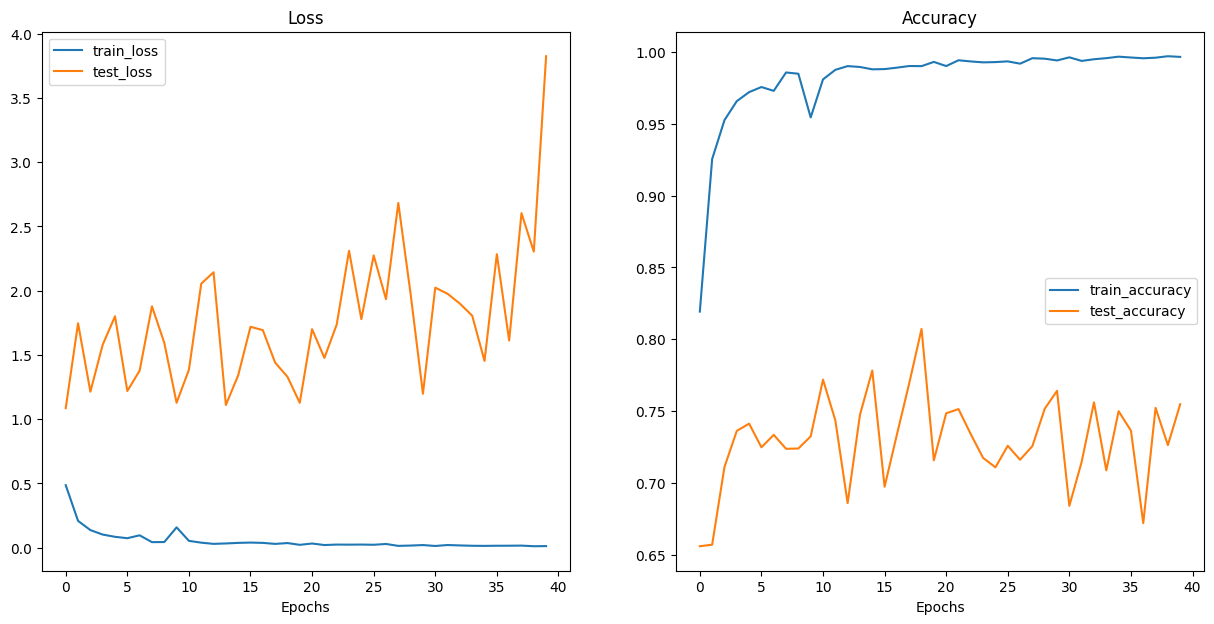

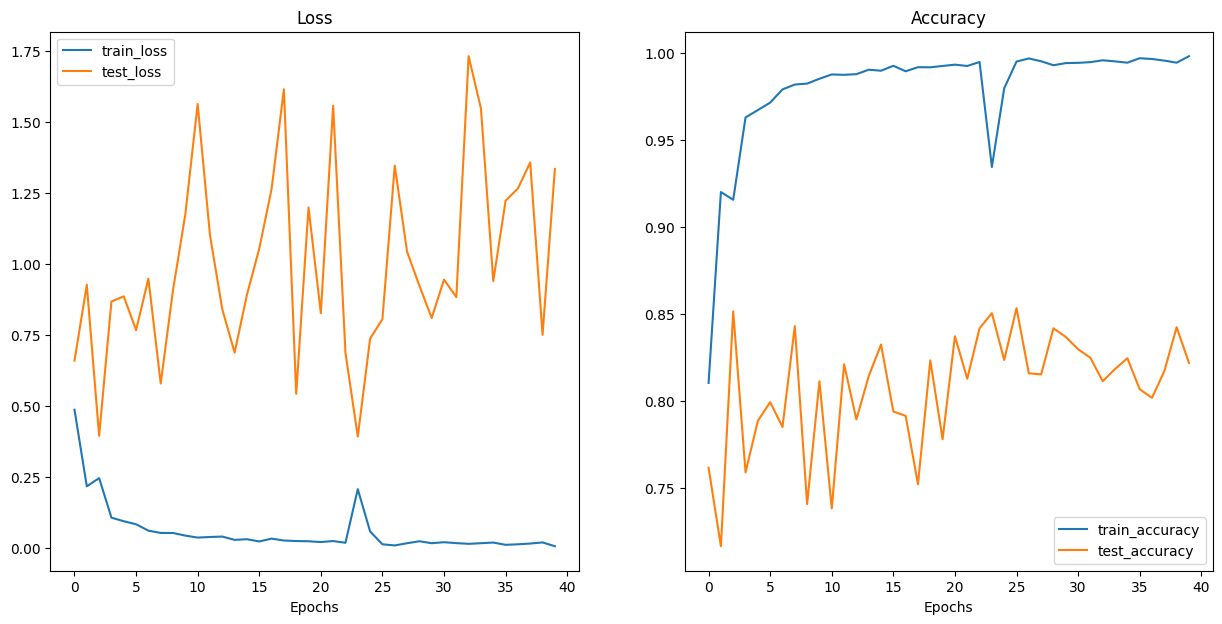

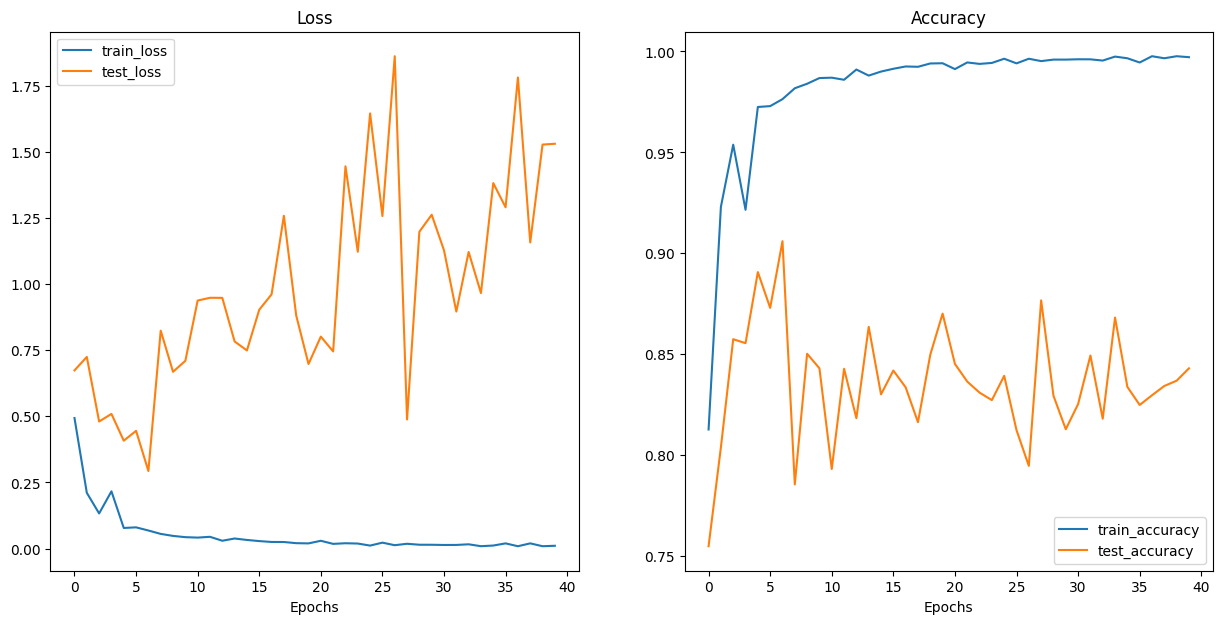

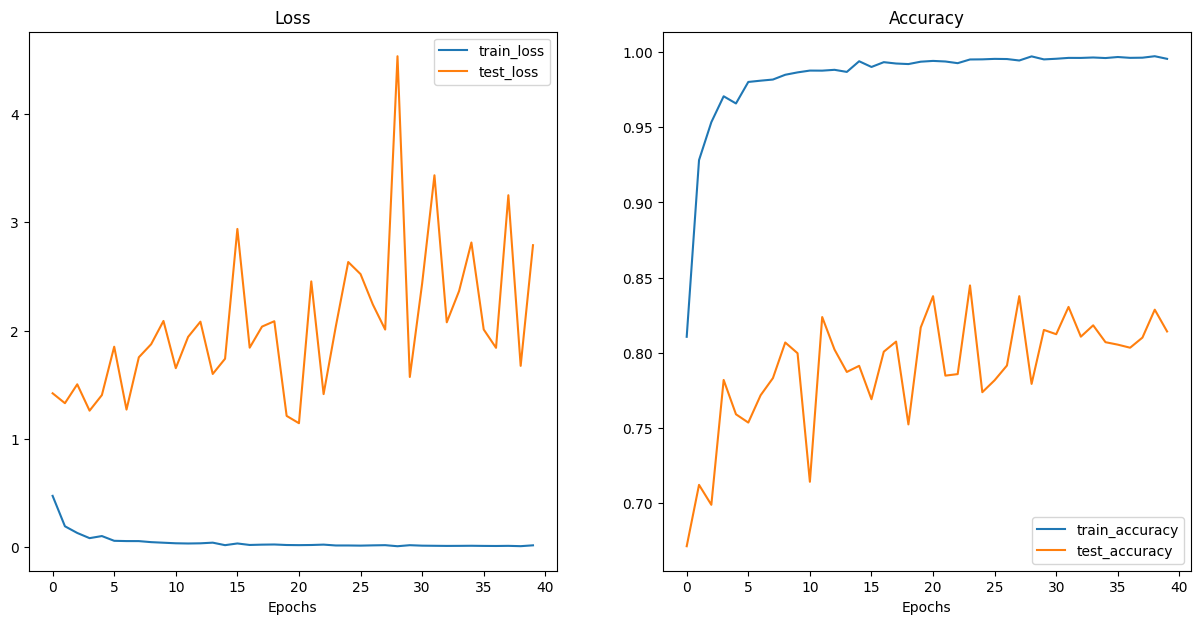

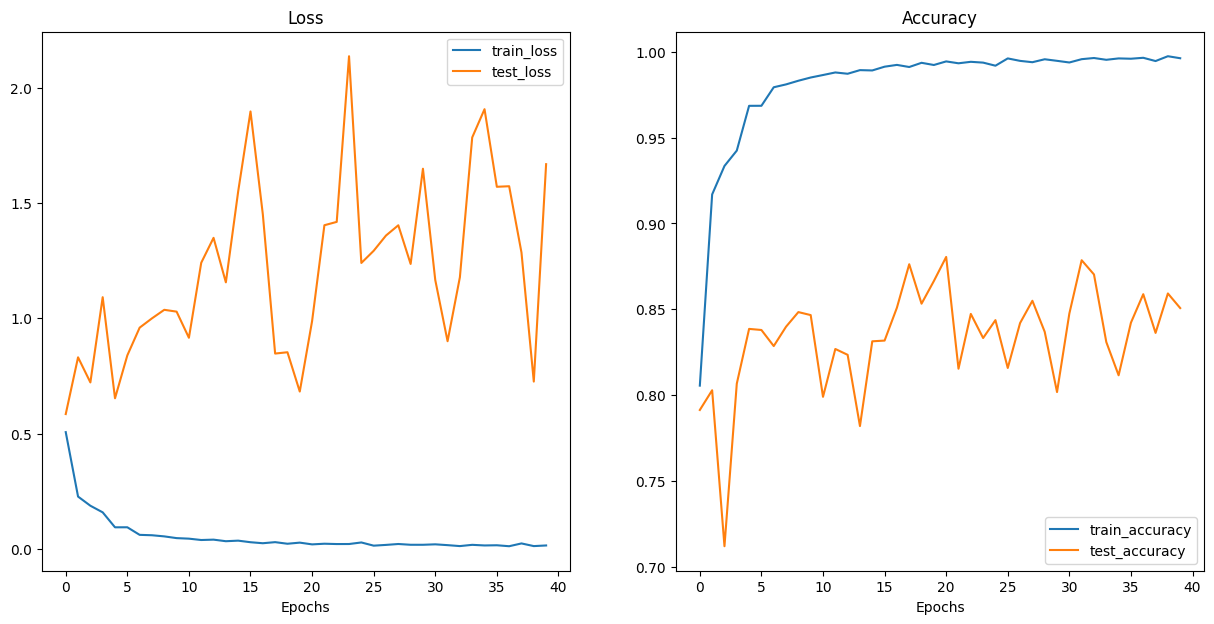

In [15]:
features = [item[1] for item in class_labels]
labels = [item[0] for item in class_labels]
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
kfold.split(features, labels)

average_validation_accuracy = []
for train_indices, test_indices in kfold.split(features, labels):
    train_data = [(labels[i], features[i]) for i in train_indices]
    test_datas = [(labels[i], features[i]) for i in test_indices]
    #print(train_indices)
    num_fold = 2
    test_features = [item[1] for item in test_datas]
    test_labels = [item[0] for item in test_datas]
    kfold_test = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=42)
    for val_indice, test_indice in kfold_test.split(test_features, test_labels):
        val_data = [(test_labels[i], test_features[i]) for i in val_indice]
        test_data = [(test_labels[i], test_features[i]) for i in test_indice]

    # For getting the value address of train image
    new_train_value=[]
    for room in train_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_train_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Train
    train_df= pd.DataFrame(data=new_train_value, columns=['labels', 'filepaths'])

    # For getting the value address of test image
    new_test_value=[]
    for room in test_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_test_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Testing
    test_df= pd.DataFrame(data=new_test_value, columns=['labels', 'filepaths'])

    # For getting the value address of Validation image
    new_val_value=[]
    for room in val_data:
        photo = os.listdir(room[1])
        for image in photo:
            new_val_value.append((room[0],str(room[1] +'/' +image)))

    #Creating the Dataframe for Validation
    val_df= pd.DataFrame(data=new_val_value, columns=['labels', 'filepaths'])


#############################################################################################################################################
    # Create data loaders
    train_gen, test_gen, valid_gen, class_names = create_dataloaders(
        train_df=train_df,
        test_df=test_df,
        val_df=val_df,
        batch_size=BATCH_SIZE
    )

    train_gen, test_gen, valid_gen, class_names
    classes=labels
    class_count=len(classes)


#############################################################################################################################################

    # Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
    model = CViT(image_size=49, patch_size=7, num_classes=4, channels=512,
            dim=1024, depth=6, heads=8, mlp_dim=2048)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)

    # Setup the loss function for multi-class classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Set the seeds
    #set_seeds()
    # Train the model and save the training results to a dictionary
    model_results = engine.train(model=model,
                           train_dataloader=train_gen,
                           valid_dataloader=valid_gen,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=EPOCHS,
                           device=device)
    average_validation_accuracy.append(model_results["test_acc"])

##############################################################################################################################################
    # we can use the plot_loss_curves function from helper_functions.py
    # Plot our ViT model's loss curves
    plot_loss_curves(model_results)


#############################################################################################################################################
    # EVALUATION
    model.eval()
    y_true=[]
    y_pred=[]
    for _,(image, label) in enumerate(test_gen):
        y_true.extend(label.cpu().numpy())
        prediction =torch.argmax(torch.softmax(model(image.to(device)),dim=1),dim=1)
        prediction=prediction.cpu().numpy()
        y_pred.extend(prediction)


    #confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion matrix: \n{cm}")

    #Metrics

    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")



-----------------------------DONE---------------------------------------

In [16]:
def test(model):
    model.eval()

    Sum = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs).to(device).float()

        _,prediction = torch.max(output,1)

        pred_label = labels[prediction]
        pred_label = pred_label.detach().cpu().numpy()
        main_label = labels.detach().cpu().numpy()
        bool_list  = list(map(lambda x, y: x == y, pred_label, main_label))
        Sum += sum(np.array(bool_list)*1)

    print('Prediction: ', (Sum/len(test_loader.dataset)*100,'%'))

In [17]:
test(model)

NameError: name 'test_loader' is not defined

In [ ]:
# TESTING
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item() * images.size(0)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)